In [1]:
import math
import numpy
import random
import matplotlib.pyplot as pl
from tqdm.notebook import tqdm, trange

In [2]:
class Neuron:
    def __init__(self, state=0.0, thr=None):
        self.thr = thr if thr is not None else (random.random() - 0.5) * 2
        self.state = state
    
    def __repr__(self):
        return '(%.2f, %.2f)' % (self.state, self.thr)
    
    def __str__(self):
        return self.__repr__()

In [3]:
class Layer:
    def __init__(self, length):
        self.length = length
        self.N = [Neuron() for i in range(length)]
    
    def broadcast(self, data):
        for i in range(self.length):
            x = i % len(data)
            self.N[i].state = data[x]

In [18]:
class Perceptron:
    def __init__(self, ilen, hlen, olen, alpha, f):
        self.act_func = f
        self.alpha = alpha
        
        self.input_layer = Layer(ilen)
        self.hidden_layer = Layer(hlen)
        self.out_layer = Layer(olen)
        
        self.iW = (numpy.random.rand(ilen, hlen) - 0.5) * 2
        self.oW = (numpy.random.rand(hlen, olen) - 0.5) * 2
        
    def predict(self, data):
        self.input_layer.broadcast(data)
        dof(self.hidden_layer, self.input_layer, self.iW, self.act_func)
        dof(self.out_layer, self.hidden_layer, self.oW, self.act_func)
        res = []
        for i in range(self.out_layer.length):
            res.append(self.out_layer.N[i].state)
        return res
    
    def forward(self, Y):
        for i in range(self.oW.shape[0]):
            for j in range(self.oW.shape[1]):
                x = self.out_layer.N[j].state
                c = self.hidden_layer.N[i].state
                self.oW[i, j] += self.alpha * x * (1 - x) * (Y[j] - x) * c

        for i in range(self.out_layer.length):
            x = self.out_layer.N[i].state
            self.out_layer.N[i].state += self.alpha * x * (1 - x) * (Y[i] - x)
    
    def backward(self, Y):
        for i in range(self.iW.shape[0]):
            for j in range(self.iW.shape[1]):
                error = 0
                for k in range(self.out_layer.length):
                    x = self.out_layer.N[k].state
                    error += (Y[k] - x) * x * (1 - x) * self.oW[j, k]
                h = self.hidden_layer.N[j].state
                self.iW[i, j] += self.alpha * self.input_layer.N[i].state * h * (1 - h) * error
                if i == 0:
                    self.hidden_layer.N[j].thr += self.alpha * h * (1 - h) * error
    
    def fit(self, X, Y, epoch=1000):
        losses = []
        for _ in range(epoch):
            pred = self.predict(X)
            pred = numpy.abs(Y - pred)
            loss = pred.max()
            self.forward(Y)
            self.backward(Y)
            losses.append(loss)
        return losses

In [13]:
def dof(h, i, w, f):
    for x in range(h.length):
        X = 0
        for y in range(i.length):
            X += w[y, x] * i.N[y].state
        h.N[x].state = f(X + h.N[x].thr)

In [86]:
def noised(data, level):
    out = data.copy()
    for x in range(out.shape[1]):
        for y in range(out.shape[0]): 
            if random.randint(0, 100) <= level:
                out[y, x] = {0: 1, 1: 0}[data[y, x]]
    return numpy.array(out, dtype=numpy.uint8)

In [72]:
def reshape(data):
    W = data.shape[0]
    w = math.sqrt(W)
    w = int(w)
    h = W // w
    return data.reshape(w, h)
def show(data, pl=pl):
    if len(data) == 1:
        data = reshape(data)
    pl.imshow(data, cmap='gray')

In [73]:
def grid(array, ncols=4, pad=2):
    if isinstance(array, list):
        array = map(lambda x: reshape(x) if len(x.shape) == 1 else x, array)
        array = numpy.array([numpy.pad(x, pad) for x in array])
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape(nrows, ncols, height, width, 1)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, 1))
    return result

In [190]:
golden = [a, b, c, d, e, ff]
answers = [numpy.pad([1], (x, len(golden)-x-1)) for x in range(0, len(golden))]
labels = ['a','b','c','d','e', 'f']
losses = [[]] * len(golden)

model = Perceptron(ilen=golden[0].shape[0], hlen=10, olen=len(golden), alpha=0.03, f=lambda x: 1.0 / (1 + math.e ** -x))

In [ ]:
fig, ax = pl.subplots(len(golden), 1, figsize=(10, 50))
batch = 8
epoch = 1000

for _ in tqdm(range(epoch)):
    for i, g in enumerate(golden):
        losses[i] += model.fit(g, answers[i], epoch=batch)

for i, g in enumerate(golden):
    ax[i].plot(losses[i], marker='.')
    # show(g, pl=ax[i][1])
    
# exam
for x, y in zip(labels, golden):
    X = model.predict(y)
    Xi = X.index(max(X))
    if x != labels[Xi]:
        print('Fail %s: %s %r' % (x, labels[Xi], X))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
a = numpy.array([
        0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0,
])

b = numpy.array([
        0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0,
])

c = numpy.array([
        0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0,
])

d = numpy.array([
        0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0,
])

e = numpy.array([
        1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0,
])

ff = numpy.array([
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0,
])

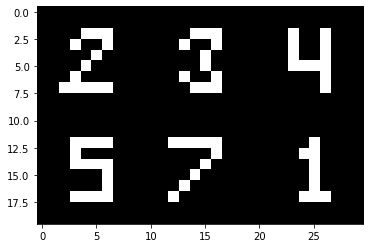

In [83]:
pl.imshow(grid(golden, 3), cmap='gray')

In [175]:
def demo(X, Y):
    ran = range(0, 100, 10)
    out = []
    for i, level in enumerate(ran):
        Xp = noised(reshape(X), level)
        out.append(Xp)
        Xp = Xp.reshape(36)
        Yp = model.predict(Xp)
        print('noise %3d%%' % (level, ))
        for x, y in zip(Yp, labels):
            print(' %s: %.1f%%' % (y, x * 100))
        print(' result %s with %.2f%%' % (labels[Yp.index(max(Yp))], max(Yp) * 100))
    return out

noise   0%
 a: 69.9%
 b: 6.7%
 c: 7.0%
 d: 1.6%
 e: 18.6%
 f: 9.4%
 result a with 69.88%
noise  10%
 a: 76.6%
 b: 10.4%
 c: 8.1%
 d: 1.6%
 e: 17.7%
 f: 14.7%
 result a with 76.64%
noise  20%
 a: 17.2%
 b: 1.0%
 c: 3.2%
 d: 11.3%
 e: 4.6%
 f: 18.4%
 result f with 18.41%
noise  30%
 a: 54.0%
 b: 2.5%
 c: 1.7%
 d: 9.9%
 e: 3.5%
 f: 26.3%
 result a with 54.00%
noise  40%
 a: 0.9%
 b: 7.3%
 c: 10.6%
 d: 43.7%
 e: 8.7%
 f: 2.4%
 result d with 43.70%
noise  50%
 a: 2.3%
 b: 14.3%
 c: 14.7%
 d: 49.2%
 e: 5.7%
 f: 4.1%
 result d with 49.24%
noise  60%
 a: 3.5%
 b: 8.2%
 c: 9.8%
 d: 6.6%
 e: 55.5%
 f: 1.5%
 result e with 55.47%
noise  70%
 a: 0.6%
 b: 27.8%
 c: 2.1%
 d: 49.1%
 e: 3.8%
 f: 12.4%
 result d with 49.12%
noise  80%
 a: 0.5%
 b: 21.5%
 c: 5.0%
 d: 74.8%
 e: 1.7%
 f: 4.1%
 result d with 74.82%
noise  90%
 a: 0.5%
 b: 43.7%
 c: 5.2%
 d: 68.6%
 e: 1.9%
 f: 10.2%
 result d with 68.57%


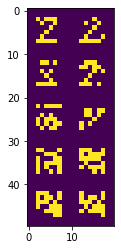

In [183]:
pl.imshow(grid(demo(a, 'a'), 2))

noise   0%
 a: 4.0%
 b: 80.9%
 c: 8.7%
 d: 8.6%
 e: 9.8%
 f: 11.9%
 result b with 80.90%
noise  10%
 a: 4.1%
 b: 59.2%
 c: 7.5%
 d: 21.4%
 e: 5.4%
 f: 8.6%
 result b with 59.24%
noise  20%
 a: 7.5%
 b: 68.4%
 c: 22.3%
 d: 3.5%
 e: 7.3%
 f: 7.3%
 result b with 68.43%
noise  30%
 a: 27.6%
 b: 37.9%
 c: 5.9%
 d: 0.6%
 e: 14.4%
 f: 10.4%
 result b with 37.86%
noise  40%
 a: 1.3%
 b: 52.5%
 c: 40.6%
 d: 29.4%
 e: 21.7%
 f: 0.6%
 result b with 52.51%
noise  50%
 a: 4.7%
 b: 47.7%
 c: 3.0%
 d: 2.7%
 e: 29.4%
 f: 10.1%
 result b with 47.65%
noise  60%
 a: 0.6%
 b: 39.3%
 c: 2.0%
 d: 30.9%
 e: 6.4%
 f: 8.3%
 result b with 39.33%
noise  70%
 a: 0.7%
 b: 29.0%
 c: 10.9%
 d: 59.8%
 e: 4.4%
 f: 2.8%
 result d with 59.82%
noise  80%
 a: 2.8%
 b: 6.9%
 c: 7.8%
 d: 26.6%
 e: 5.9%
 f: 3.9%
 result d with 26.56%
noise  90%
 a: 2.9%
 b: 5.3%
 c: 3.7%
 d: 21.3%
 e: 8.5%
 f: 4.6%
 result d with 21.33%


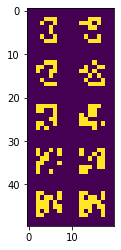

In [184]:
pl.imshow(grid(demo(b, 'b'), 2))

noise   0%
 a: 9.8%
 b: 7.1%
 c: 81.7%
 d: 11.4%
 e: 5.7%
 f: 1.6%
 result c with 81.67%
noise  10%
 a: 8.2%
 b: 8.1%
 c: 69.7%
 d: 12.6%
 e: 7.2%
 f: 2.2%
 result c with 69.73%
noise  20%
 a: 5.0%
 b: 5.1%
 c: 60.6%
 d: 27.5%
 e: 3.4%
 f: 3.1%
 result c with 60.60%
noise  30%
 a: 9.3%
 b: 2.0%
 c: 17.4%
 d: 50.9%
 e: 0.4%
 f: 16.2%
 result d with 50.85%
noise  40%
 a: 0.9%
 b: 6.6%
 c: 25.8%
 d: 84.6%
 e: 8.9%
 f: 13.0%
 result d with 84.63%
noise  50%
 a: 15.2%
 b: 18.8%
 c: 26.7%
 d: 1.8%
 e: 22.8%
 f: 1.0%
 result c with 26.70%
noise  60%
 a: 4.0%
 b: 3.4%
 c: 0.5%
 d: 23.3%
 e: 7.2%
 f: 10.4%
 result d with 23.27%
noise  70%
 a: 2.6%
 b: 32.7%
 c: 0.4%
 d: 12.7%
 e: 2.9%
 f: 54.8%
 result f with 54.81%
noise  80%
 a: 2.0%
 b: 3.8%
 c: 0.9%
 d: 35.7%
 e: 4.2%
 f: 13.8%
 result d with 35.68%
noise  90%
 a: 1.6%
 b: 23.2%
 c: 0.3%
 d: 23.0%
 e: 4.4%
 f: 34.1%
 result f with 34.13%


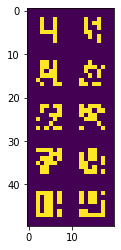

In [185]:
pl.imshow(grid(demo(c, 'c'), 2))

noise   0%
 a: 0.7%
 b: 6.5%
 c: 11.6%
 d: 84.8%
 e: 0.6%
 f: 11.3%
 result d with 84.79%
noise  10%
 a: 0.9%
 b: 10.3%
 c: 6.8%
 d: 71.1%
 e: 0.6%
 f: 30.7%
 result d with 71.12%
noise  20%
 a: 1.2%
 b: 11.0%
 c: 20.4%
 d: 70.4%
 e: 1.4%
 f: 6.2%
 result d with 70.40%
noise  30%
 a: 5.0%
 b: 30.6%
 c: 1.5%
 d: 4.1%
 e: 13.1%
 f: 19.9%
 result b with 30.59%
noise  40%
 a: 12.3%
 b: 1.9%
 c: 16.6%
 d: 10.1%
 e: 3.8%
 f: 9.7%
 result c with 16.62%
noise  50%
 a: 8.3%
 b: 3.7%
 c: 8.3%
 d: 10.4%
 e: 12.8%
 f: 9.0%
 result e with 12.82%
noise  60%
 a: 4.4%
 b: 33.1%
 c: 4.6%
 d: 6.1%
 e: 36.2%
 f: 4.8%
 result e with 36.22%
noise  70%
 a: 6.0%
 b: 1.1%
 c: 2.4%
 d: 21.7%
 e: 1.3%
 f: 18.8%
 result d with 21.69%
noise  80%
 a: 2.6%
 b: 48.5%
 c: 0.9%
 d: 5.9%
 e: 24.6%
 f: 28.6%
 result b with 48.48%
noise  90%
 a: 5.8%
 b: 18.2%
 c: 10.3%
 d: 2.1%
 e: 88.4%
 f: 2.0%
 result e with 88.37%


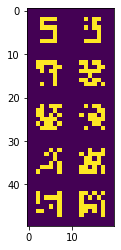

In [186]:
pl.imshow(grid(demo(d, 'd'), 2))

noise   0%
 a: 11.2%
 b: 8.7%
 c: 7.1%
 d: 1.1%
 e: 85.4%
 f: 0.8%
 result e with 85.44%
noise  10%
 a: 7.7%
 b: 8.3%
 c: 7.7%
 d: 0.9%
 e: 79.9%
 f: 0.8%
 result e with 79.91%
noise  20%
 a: 1.5%
 b: 32.0%
 c: 22.0%
 d: 10.5%
 e: 41.5%
 f: 0.5%
 result e with 41.52%
noise  30%
 a: 4.2%
 b: 27.0%
 c: 53.5%
 d: 36.8%
 e: 29.1%
 f: 4.6%
 result c with 53.51%
noise  40%
 a: 5.6%
 b: 25.6%
 c: 64.8%
 d: 7.7%
 e: 13.8%
 f: 0.7%
 result c with 64.82%
noise  50%
 a: 11.2%
 b: 1.8%
 c: 15.4%
 d: 19.4%
 e: 7.7%
 f: 14.3%
 result d with 19.40%
noise  60%
 a: 1.7%
 b: 7.3%
 c: 1.8%
 d: 49.4%
 e: 2.8%
 f: 13.4%
 result d with 49.42%
noise  70%
 a: 1.9%
 b: 3.9%
 c: 4.3%
 d: 49.1%
 e: 2.0%
 f: 14.9%
 result d with 49.11%
noise  80%
 a: 0.6%
 b: 74.6%
 c: 10.8%
 d: 46.0%
 e: 3.0%
 f: 22.2%
 result b with 74.57%
noise  90%
 a: 0.5%
 b: 15.0%
 c: 8.3%
 d: 86.6%
 e: 0.7%
 f: 18.1%
 result d with 86.58%


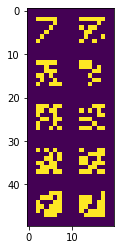

In [187]:
pl.imshow(grid(demo(e, 'e'), 2))

noise   0%
 a: 12.7%
 b: 10.8%
 c: 1.7%
 d: 8.3%
 e: 1.1%
 f: 77.3%
 result f with 77.30%
noise  10%
 a: 3.3%
 b: 14.5%
 c: 1.6%
 d: 20.6%
 e: 0.9%
 f: 71.0%
 result f with 71.02%
noise  20%
 a: 4.9%
 b: 3.5%
 c: 1.1%
 d: 25.2%
 e: 2.5%
 f: 40.6%
 result f with 40.55%
noise  30%
 a: 13.8%
 b: 3.0%
 c: 3.7%
 d: 31.1%
 e: 3.2%
 f: 28.7%
 result d with 31.12%
noise  40%
 a: 3.5%
 b: 16.4%
 c: 1.7%
 d: 9.1%
 e: 12.7%
 f: 3.5%
 result b with 16.36%
noise  50%
 a: 2.5%
 b: 15.9%
 c: 30.0%
 d: 38.8%
 e: 5.9%
 f: 2.8%
 result d with 38.81%
noise  60%
 a: 12.4%
 b: 4.4%
 c: 3.2%
 d: 3.4%
 e: 5.3%
 f: 4.6%
 result a with 12.37%
noise  70%
 a: 0.9%
 b: 12.0%
 c: 2.0%
 d: 18.6%
 e: 27.5%
 f: 5.8%
 result e with 27.50%
noise  80%
 a: 2.3%
 b: 30.6%
 c: 23.2%
 d: 6.9%
 e: 50.6%
 f: 0.4%
 result e with 50.59%
noise  90%
 a: 1.8%
 b: 20.6%
 c: 8.5%
 d: 15.7%
 e: 24.9%
 f: 1.1%
 result e with 24.95%


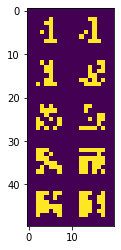

In [188]:
pl.imshow(grid(demo(ff, 'f'), 2))